#  Crypto Trading Bot EDA- TEAM 139

## Description


The project consists of a cryptocurrency investment tool that will make trading decisions seeking to maximize profit on a portfolio with a given investment time horizon. To achieve this goal, we will develop a price prediction model based on two components: public information from the cryptocurrency market, and a natural language processing model that captures relevant signals coming from social media such as Twitter. Finally, we will design a dashboard to monitor the results of our investment tool.

Here we present an exploratory analysis of the cryptocurrency data retrieved from different sources. 

## Information sources


Market economic information. For this, the historical records of each cryptocurrency and the supply and demand at exact times would be needed. This information will be obtained from the following API:


 1.  https://finance.yahoo.com/\. In its free version, we have a total of 5000 requests/day.
 2.  https://polygon.io/ . In its free version, we have a total of 5 requests-minute.
 3.  https://www.alphavantage.co/\. In its free version, we have a total of 500 requests/day.



The following code will import care of importing the necessary configuration from the APIs

In [63]:
from app.log import logging_config
from os.path import dirname, join
from dotenv import load_dotenv
import logging
from app.util.message import starting_message
from app import yahoo_finance, Polygon, Alphavantage
import pandas as pd
import time
from datetime import datetime 

In [64]:
#print(join(dirname(__file__), '.env'))
#load_dotenv(dotenv_path=join(dirname(__file__), '.env'))
load_dotenv()
from os import environ
print(environ.get("POLYGON_KEY"))
print(environ.get("ALPHA_KEY"))

PWRjSfmBc9xYnPZMQhA9ukDOuOIId90D
4RBB1VWACSPNF8DH


In [65]:
logging_config.init_logging()
__LOG = logging.getLogger(__name__)
__LOG.info('...... Initialization Completed  ......')
__LOG.info(starting_message())

# Yahoo Finance

*Yfinance* is a public package that can be installed using “pip install finance”.  It gets daily and real-time market information from different cryptocurrency symbols. This package allows us to access the **open**, **maximum**, **minimum**, and **close** prices from the cryptocurrency symbol of our interest for a selected time window. Additionally, we can get the traded **volume** for the same period.

In [66]:
status, yahoo_data = yahoo_finance.market_value('BTC-USD')
if status:
    print(status)

yahoodf = pd.DataFrame(yahoo_data, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
#yahoodf['Date'] = yahoodf.index
yahoodf = yahoodf.reset_index(level=0)
yahoodf.head()

[*********************100%***********************]  1 of 1 completed
True


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-16,7153.663086,7518.033203,6540.049316,7511.588867,7511.588867,165399102665
1,2019-12-23,7508.902344,7656.176270,7189.934082,7422.652832,7422.652832,161758217053
2,2019-12-30,7420.272949,7544.497070,6914.996094,7411.317383,7411.317383,149690652648
3,2020-01-06,7410.452148,8396.738281,7409.292969,8192.494141,8192.494141,184901289966
4,2020-01-13,8189.771973,9164.362305,8079.700684,8706.245117,8706.245117,241668743794


The following are the columns in the dataset:

1. **Date**: The date requested of the cryptocurrency symbol data. 
2. **Open**: The open price for the symbol in the given time period.
3. **High**: The highest price for the symbol in the giben time period.
4. **Low**: The lowest price for the symbol in the giben time period.
5. **Close**: The close price for the symbol in the given time period.
6. **Adj Close**: Adjusted close price for the symbol in the given time period.
7. **Volume**: The trading volume of the symbol in the given time period.

In [67]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

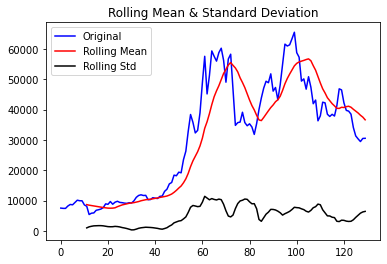

Results of Dickey-Fuller Test:
Test Statistic                  -1.596519
p-value                          0.485342
#Lags Used                       4.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64


In [68]:
test_stationarity(yahoodf.Close)

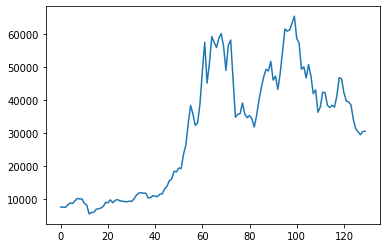

In [69]:
moving_avg = pd.Series(yahoodf.Close).rolling(window=800).mean()
plt.plot(yahoodf.Close)
plt.plot(moving_avg, color='red')

In [70]:
yahoodf.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [71]:
#Numeric Variables
yahoodf[['Open','High', 'Low', 'Close', 'Adj Close', 'Volume']].describe()

,Open,High,Low,Close,Adj Close,Volume
count,130.000000,130.000000,130.000000,130.000000,130.000000,1.300000e+02
mean,30444.030874,32746.064078,28052.277926,30626.786512,30626.786512,2.625356e+11
std,18584.397620,19793.374854,16918.084969,18471.415764,18471.415764,1.117944e+11
min,5385.229492,6844.261719,4106.980957,5392.314941,5392.314941,2.778075e+10
25%,10156.919189,10670.465332,9907.100586,10291.202637,10291.202637,1.883245e+11
50%,34466.568359,37149.000000,30468.601562,34444.916016,34444.916016,2.400504e+11
75%,46437.929688,48618.506836,42641.817383,46455.435547,46455.435547,3.015578e+11
max,65521.289062,68789.625000,62333.914062,65466.839844,65466.839844,7.666798e+11


At first glance, there do not appear to be any outlier problems in the sample. However, the cryptocurrency price variables mean is lower than the median, so the price distribution over the 131 dates consulted is not symmetrical. It seems that cryptocurrency price information presents a wide range of values below the median. 

In [72]:
pd.DatetimeIndex(yahoodf['Date']).year.value_counts()

2020    52
2021    52
2022    23
2019     3
Name: Date, dtype: int64

## Polygon

Polygon is a financial market data platform. Here we can get access to cryptocurrency  information constantly, dynamically, and in real-time. Additionally, this platform has an API in which we can get news for each currency we need to analyze.

We start by consuming the relevant information for market status, news and daily closings of the cryptocurrency market.

### Market Status

Get the current trading status of the exchanges and overall financial markets.

In [73]:
polygon=Polygon(environ.get("POLYGON_KEY"))
#print('polygon')
status, polygon_data = polygon.get_market_status()
if status:
    #print(polygon_data)
    polygon_market_status = pd.DataFrame.from_dict(polygon_data)
polygon_market_status = polygon_market_status.reset_index(level=0)
polygon_market_status

,index,market,earlyHours,afterHours,serverTime,exchanges,currencies
0,nyse,closed,False,False,2022-06-03T02:17:36-04:00,closed,NaN
1,nasdaq,closed,False,False,2022-06-03T02:17:36-04:00,closed,NaN
2,otc,closed,False,False,2022-06-03T02:17:36-04:00,closed,NaN
3,fx,closed,False,False,2022-06-03T02:17:36-04:00,NaN,open
4,crypto,closed,False,False,2022-06-03T02:17:36-04:00,NaN,open


Here is a description of the imported columns:

1. **index**: Exchanges and overall financial markets.
2. **market**: The status of the market as a whole.
3. **earlyHours**: Whether or not the market is in pre-market hours.
4. **afterHours**: Whether or not the market is in post-market hours.
5. **serverTime**: The current time of the server.
6. **exchanges**: The status of the Nasdaq, NYSE and OTC market.
7. **currencies**: The status of the crypto market.



We start with exploring the type of each of the columns in the dataframe:

In [74]:
polygon_market_status['serverTime'] = pd.to_datetime(polygon_market_status['serverTime'])
polygon_market_status.dtypes

index                                         object
market                                        object
earlyHours                                      bool
afterHours                                      bool
serverTime    datetime64[ns, pytz.FixedOffset(-240)]
exchanges                                     object
currencies                                    object
dtype: object

Next with the general distribution of the data in the dataframe:

In [75]:
polygon_market_status.describe()

C:\Users\julia\AppData\Local\Temp\ipykernel_2260\3545403409.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  polygon_market_status.describe()


,index,market,earlyHours,afterHours,serverTime,exchanges,currencies
count,5,5,5,5,5,3,2
unique,5,1,1,1,1,1,1
top,nyse,closed,False,False,2022-06-03 02:17:36-04:00,closed,open
freq,1,5,5,5,5,3,2
first,NaN,NaN,NaN,NaN,2022-06-03 02:17:36-04:00,NaN,NaN
last,NaN,NaN,NaN,NaN,2022-06-03 02:17:36-04:00,NaN,NaN


### Ticker News

Get the most recent news articles relating to a stock ticker symbol, including a summary of the article and a link to the original source.

In [76]:
status, polygon_data = polygon.get_news_ticker('2021-08-16', 'ETH')
if status:
    #print(polygon_data)
    polygon_news_ticker = pd.DataFrame.from_dict(polygon_data['results'])
for i in polygon_news_ticker.index:
    polygon_news_ticker_pbs = polygon_news_ticker['publisher'][i]['name']
    polygon_news_ticker['publisher'][i] = polygon_news_ticker_pbs
polygon_news_ticker

,id,publisher,title,author,published_utc,article_url,tickers,amp_url,image_url,description
0,3gsHFlxYpqd4mO7JVsy9xGKW7RvSIWWN_pH6gBsxZ8M,Zacks Investment Research,Top Ranked Momentum Stocks to Buy for August 16th,Zacks Equity Research,2021-08-16T14:39:00Z,https://www.zacks.com/commentary/1782237/top-r...,"[DDS, ETH, AAWW, MHO]",https://www.zacks.com/amp/commentary/1782237/t...,https://staticx-tuner.zacks.com/images/article...,"DDS, AAWW, ETH, and MHO made it to the Zacks R..."
1,Gbai-oSYsx-7b5hHh50sRZryB4mfuaHaEGryAZ6LQy0,Zacks Investment Research,Top Ranked Income Stocks to Buy for August 16th,Zacks Equity Research,2021-08-16T13:30:00Z,https://www.zacks.com/commentary/1782122/top-r...,"[WSR, NYCB, ETH, FANH]",https://www.zacks.com/amp/commentary/1782122/t...,https://staticx-tuner.zacks.com/images/article...,"NYCB, WSR, FANH, and ETH made it to the Zacks ..."


Here is a description of the imported columns:

1. **id**: Unique identifier for the article.
2. **publisher**: The publisher's name.
3. **title**: The title of the news article.
4. **author**: The article's author.
5. **published_utc**: The date the article was published on.
6. **article_url**: A link to the news article.
7. **tickers**: The ticker symbols associated with the article.
8. **amp_url**: The mobile friendly Accelerated Mobile Page (AMP) URL.
9. **image_url**: The article's image URL.
10. **description**: A description of the article.



We start with exploring the type of each of the columns in the dataframe:

In [77]:
polygon_news_ticker.dtypes

id               object
publisher        object
title            object
author           object
published_utc    object
article_url      object
tickers          object
amp_url          object
image_url        object
description      object
dtype: object

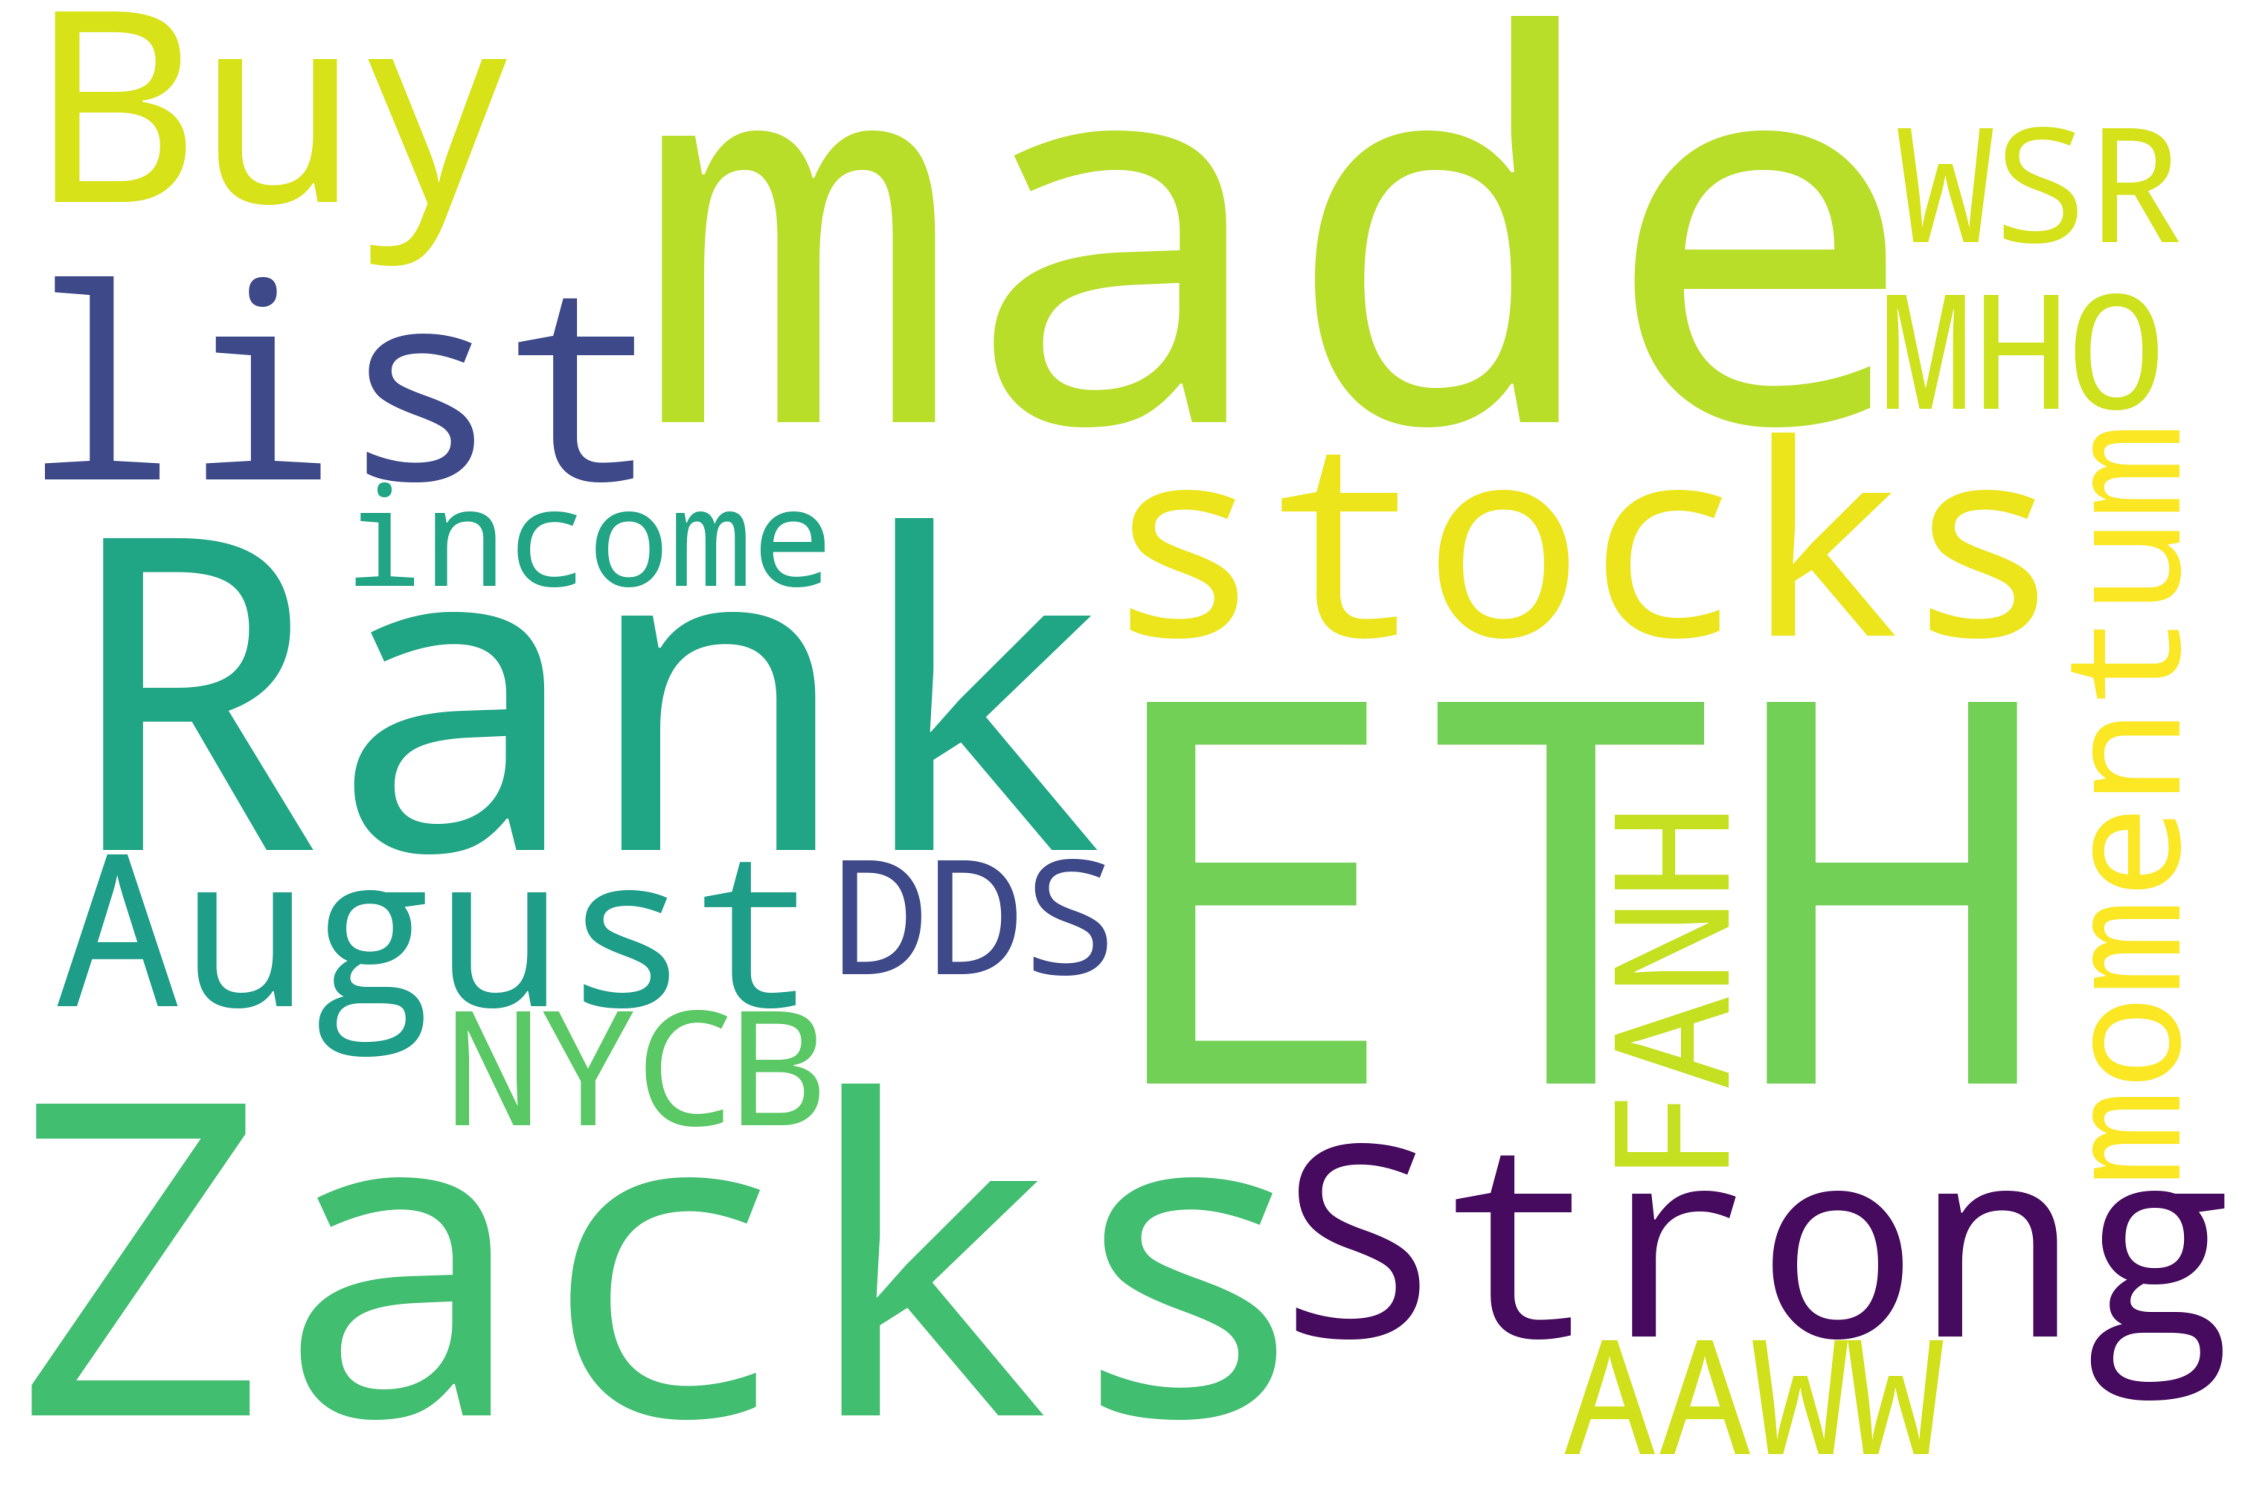

In [78]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

text = ''
for x in polygon_news_ticker['description']:
    text = text + ' ' + x
    
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

### Ticker News (Older)

Get the oldest related news articles with a summary of the article and a link to the original source.

In [79]:
status, polygon_data_on = polygon.get_old_news('2022-05-31')
#print(status)
if status:
    #print(polygon_data)
    polygon_old_news = pd.DataFrame.from_dict(polygon_data_on["results"])
#polygon_old_news
polygon_old_news = polygon_old_news[['title', 'author', 'published_utc', 'tickers', 'description', 'keywords']]
n_columns_news = {'title':'Title', 'author':'Author', 'published_utc':'Date', 'tickers':'Tickers', 'description':'Description', 'keywords':'Keywords'}
polygon_old_news.rename(columns = n_columns_news, inplace = True)
polygon_old_news.head()

,Title,Author,Date,Tickers,Description,Keywords
0,The Limestone Boat Company Announces First Qua...,The Limestone Boat Company Limited,2022-05-31T01:51:00Z,[BOAT],"Limestone continues to grow unit production, r...",[Earnings Releases and Operating Results]
1,Shiba Inu (SHIB) Founder Ryoshi Abruptly Delet...,Samyuktha Sriram,2022-05-31T02:52:56Z,[TWTR],"Ryoshi, the pseudonymous creator behind meme c...","[News, Cryptocurrency, Social Media, Top Stori..."
2,Apple Will Have To Face Antitrust Lawsuit From...,Shivdeep Dhaliwal,2022-05-31T03:16:09Z,[AAPL],Apple Inc’s (NASDAQ: AAPL) attempts to have an...,"[News, Legal, Tech, Media]"
3,"Why Alibaba, Nio, Chinese Peers Are Struggling...",Navdeep Yadav,2022-05-31T04:07:22Z,"[BABA, JD, NIO, XPEV]",Shares of U.S.-listed Chinese companies were n...,"[News, Asia, Top Stories, Markets, Movers, Tec..."
4,Coinbase Institutional Clients Raised Bitcoin ...,Samyuktha Sriram,2022-05-31T04:20:15Z,[COIN],Data shows that institutions on Coinbase Globa...,"[News, Cryptocurrency, Markets]"


Here is a description of the imported columns:

1. **Title**: The title of the news article.
2. **Author**: The article's author.
3. **Date**: The date the article was published on.
4. **Tickers**: The ticker symbols associated with the article.
5. **Description**: A description of the article.
6. **Keyword**: The keywords associated with the article (which will vary depending on the publishing source).


We start by exploring the type of each of the columns along with the data count in the dataframe:

In [80]:
polygon_old_news['Date'] = pd.to_datetime(polygon_old_news['Date'])
polygon_old_news.dtypes

Title                       object
Author                      object
Date           datetime64[ns, UTC]
Tickers                     object
Description                 object
Keywords                    object
dtype: object

In [81]:
polygon_old_news.describe()

C:\Users\julia\AppData\Local\Temp\ipykernel_2260\2004128356.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  polygon_old_news.describe()


,Title,Author,Date,Tickers,Description,Keywords
count,1000,1000,1000,1000,980,563
unique,992,369,644,861,950,147
top,Why This 1 Growth Stock Could Be a Great Addit...,Zacks Equity Research,2022-05-31 20:05:00+00:00,[TSLA],"Whether you're a value, growth, or momentum in...",[investing]
freq,3,311,19,9,11,119
first,NaN,NaN,2022-05-31 01:51:00+00:00,NaN,NaN,NaN
last,NaN,NaN,2022-06-01 13:40:08+00:00,NaN,NaN,NaN


In [82]:
countAnalisis_polygon_old_news = polygon_old_news[["Title", "Author", "Date", "Tickers", "Description", "Keywords"]].count()
countAnalisis_polygon_old_news

Title          1000
Author         1000
Date           1000
Tickers        1000
Description     980
Keywords        563
dtype: int64

### Ticker News (Date)

Get news articles on a given date including a summary of the article and a link to the original source.

In [83]:
status, polygon_data_on = polygon.get_news('2022-05-31')
#print(status)
if status:
    #print(polygon_data)
    polygon_get_news = pd.DataFrame.from_dict(polygon_data_on["results"])
#polygon_get_news.head()
polygon_get_news = polygon_get_news[['title', 'author', 'published_utc', 'tickers', 'description', 'keywords']]
polygon_get_news.rename(columns = n_columns_news, inplace = True)
polygon_get_news.head()

,Title,Author,Date,Tickers,Description,Keywords
0,IDT (IDT) Q3 2022 Earnings Call Transcript,newsfeedback@fool.com (Motley Fool Transcribing),2022-06-03T06:00:22Z,[IDT],IDT earnings call for the period ending March ...,[earningscall-transcripts]
1,Okta (OKTA) Q1 2023 Earnings Call Transcript,newsfeedback@fool.com (Motley Fool Transcribing),2022-06-03T06:00:19Z,[OKTA],OKTA earnings call for the period ending March...,[earningscall-transcripts]
2,Where Did All The Sellers Go And Where Are We ...,Jani Ziedins,2022-06-03T06:00:00Z,[MSFT],NaN,NaN
3,Coinbase To Rescind Several Job Offers Amid Be...,Samyuktha Sriram,2022-06-03T05:05:06Z,[COIN],Major cryptocurrency exchange Coinbase Global ...,"[News, Short Sellers, Cryptocurrency, Markets]"
4,"An Optimist Would Say Tesla Is Worth $400, May...",Paul Franke,2022-06-03T04:45:58Z,"[F, GM, HMC, RACE, STLA, TM, TTM, TSLA]",Tesla's normalized math-based valuation remain...,NaN


Here is a description of the imported columns:

1. **Title**: The title of the news article.
2. **Author**: The article's author.
3. **Date**: The date the article was published on.
4. **Tickers**: The ticker symbols associated with the article.
5. **Description**: A description of the article.
6. **Keyword**: The keywords associated with the article (which will vary depending on the publishing source).

We start by exploring the type of each of the columns along with the data count in the dataframe:

In [84]:
polygon_get_news['Date'] = pd.to_datetime(polygon_get_news['Date'])
polygon_get_news.dtypes

Title                       object
Author                      object
Date           datetime64[ns, UTC]
Tickers                     object
Description                 object
Keywords                    object
dtype: object

In [85]:
polygon_get_news.describe()

C:\Users\julia\AppData\Local\Temp\ipykernel_2260\740367754.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  polygon_get_news.describe()


,Title,Author,Date,Tickers,Description,Keywords
count,1000,1000,1000,1000,985,489
unique,997,301,615,852,963,131
top,Breaking Down the Tech Sector's Earnings Outlook,Zacks Equity Research,2022-06-02 20:05:00+00:00,[DJIA],"Here at Zacks, our focus is on the proven Zack...",[investing]
freq,2,379,20,8,9,131
first,NaN,NaN,2022-06-01 21:45:19+00:00,NaN,NaN,NaN
last,NaN,NaN,2022-06-03 06:00:22+00:00,NaN,NaN,NaN


### Ticker News (Daily)

Get news articles given a date or a series of dates including a summary of the article and a link to the original source.

In [86]:
daily_results = pd.DataFrame()
#dates3 = ['2022-01-07', '2022-01-14', '2022-01-21', '2022-01-28', '2022-02-04', '2022-02-11', '2022-02-18', '2022-02-25', '2022-03-04', '2022-03-11', '2022-03-18', '2022-03-25', '2022-04-01', '2022-04-08', '2022-04-15', '2022-04-22', '2022-04-29', '2022-05-06', '2022-05-13', '2022-05-20', '2022-05-27']
dates = ['2022-01-07', '2022-01-14', '2022-01-21', '2022-01-28', '2022-02-04', '2022-02-11', '2022-02-18', '2022-02-25', '2022-03-04', '2022-03-11', '2022-03-18', '2022-03-25', '2022-04-01', '2022-04-08', '2022-04-15', '2022-04-22', '2022-04-29', '2022-05-06', '2022-05-13', '2022-05-20', '2022-05-27']

In [87]:
for element in dates:
    #print(element)
    status, polygon_data = polygon.daily_result('BTC', element)
    if status:
        #print(polygon_data)
        polygon_daily_result = pd.DataFrame.from_dict(polygon_data)
    polygon_daily_result = polygon_daily_result.head(1)
    #polygon_daily_result

    polygon_daily_result_open = pd.DataFrame.from_dict(polygon_daily_result['openTrades'][0])

    n_columns_news3 = {'x':'ExchangeOpen', 'p':'PriceOpen', 's':'VolumeOpen', 'c':'ConditionCodesOpen', 'i':'IdOpen', 't':'TimestampOpen'}
    polygon_daily_result_open.rename(columns = n_columns_news3, inplace = True)
    #polygon_daily_result_open.head()

    polygon_daily_result_close = pd.DataFrame.from_dict(polygon_daily_result['closingTrades'][0])


    n_columns_news2 = {'x':'ExchangeClose', 'p':'PriceClose', 's':'VolumeClose', 'c':'ConditionCodesClose', 'i':'IdClose', 't':'TimestampClose'}
    polygon_daily_result_close.rename(columns = n_columns_news2, inplace = True)
    #polygon_daily_result_close.head()

    polygon_daily_result = polygon_daily_result[['symbol', 'isUTC', 'day', 'open', 'close']]
    #polygon_daily_result.join(polygon_daily_result_open)
    polygon_daily_result = pd.concat([polygon_daily_result,polygon_daily_result_open], axis = 1)
    polygon_daily_result = pd.concat([polygon_daily_result,polygon_daily_result_close], axis = 1)
    #polygon_daily_result.head()

    daily_results = daily_results.append(polygon_daily_result, ignore_index=True)
    time.sleep(15)

daily_results['DateOpen'] = pd.to_datetime(daily_results['TimestampOpen']/1000, unit='s')
daily_results['DateClose'] = pd.to_datetime(daily_results['TimestampClose']/1000, unit='s')
daily_results.head()

,symbol,isUTC,day,open,close,ExchangeOpen,PriceOpen,VolumeOpen,ConditionCodesOpen,IdOpen,TimestampOpen,ExchangeClose,PriceClose,VolumeClose,ConditionCodesClose,IdClose,TimestampClose,DateOpen,DateClose
0,BTC-USD,True,2022-01-07T00:00:00Z,43081.79,41564.61,1,43081.79,0.000675,2,260333638,1641513600010,1,41564.61,0.000247,1,260893471,1641599999913,2022-01-07 00:00:00.009999872,2022-01-07 23:59:59.913000192
1,BTC-USD,True,2022-01-14T00:00:00Z,42576.27,43086.89,1,42576.27,0.001000,2,263672878,1642118400058,1,43086.89,0.000779,1,264133049,1642204799588,2022-01-14 00:00:00.058000128,2022-01-14 23:59:59.588000000
2,BTC-USD,True,2022-01-21T00:00:00Z,40671.77,36456.96,1,40671.77,0.000120,2,266526967,1642723200089,1,36456.96,0.001000,2,267665914,1642809599827,2022-01-21 00:00:00.088999936,2022-01-21 23:59:59.826999808
3,BTC-USD,True,2022-01-28T00:00:00Z,37188.37,37741.59,1,37188.37,0.000080,1,271657003,1643328000218,1,37741.59,0.000960,1,272374175,1643414399859,2022-01-28 00:00:00.217999872,2022-01-28 23:59:59.859000064
4,BTC-USD,True,2022-02-04T00:00:00Z,37367.00,41614.66,2,37367.00,0.005000,2,991190639,1643932800019,1,41614.66,0.006329,2,276280906,1644019199952,2022-02-04 00:00:00.019000064,2022-02-04 23:59:59.952000000


Here is a description of the imported columns:

1. **symbol**: The symbol pair that was evaluated from the request.
2. **isUTC**: Whether or not the timestamps are in UTC timezone.
3. **day**: The date requested.
4. **open**: The open price for the symbol in the given time period.
5. **close**: The close price for the symbol in the given time period.
6. **ExchangeOpen**: The exchange that this crypto trade happened on.
6. **PriceOpen**: The price of the trade. This is the actual dollar value per whole share of this trade. A trade of 100 shares with a price of $2.00 would be worth a total dollar value of $200.00.
6. **VolumeOpen**: The size of a trade (also known as volume).
6. **ConditionCodesOpen**: A list of condition codes.
6. **IdOpen**: The Trade ID which uniquely identifies a trade. These are unique per combination of ticker, exchange, and TRF. For example: A trade for AAPL executed on NYSE and a trade for AAPL executed on NASDAQ could potentially have the same Trade ID.
6. **TimestampOpen**: The Unix Msec timestamp for the start of the aggregate window.
6. **ExchangeClose**: The exchange that this crypto trade happened on.
6. **PriceClose**: The price of the trade. This is the actual dollar value per whole share of this trade. A trade of 100 shares with a price of $2.00 would be worth a total dollar value of $200.00.
6. **VolumeClose**: The size of a trade (also known as volume).
6. **ConditionCodesClose**: A list of condition codes.
6. **IdClose**: The Trade ID which uniquely identifies a trade. These are unique per combination of ticker, exchange, and TRF. For example: A trade for AAPL executed on NYSE and a trade for AAPL executed on NASDAQ could potentially have the same Trade ID.
6. **TimestampClose**: The Unix Msec timestamp for the start of the aggregate window.
6. **DateOpen**: The Date for the start of the aggregate window (Open).
6. **DateClose**: The Date for the start of the aggregate window (Close).

We start by exploring the type of each of the columns along with the data count in the dataframe:

In [88]:
daily_results['day'] = pd.to_datetime(daily_results['day'])
daily_results.dtypes

symbol                              object
isUTC                                 bool
day                    datetime64[ns, UTC]
open                               float64
close                              float64
ExchangeOpen                         int64
PriceOpen                          float64
VolumeOpen                         float64
ConditionCodesOpen                   int64
IdOpen                              object
TimestampOpen                        int64
ExchangeClose                        int64
PriceClose                         float64
VolumeClose                        float64
ConditionCodesClose                  int64
IdClose                             object
TimestampClose                       int64
DateOpen                    datetime64[ns]
DateClose                   datetime64[ns]
dtype: object

In [89]:
daily_results.describe()

,open,close,ExchangeOpen,PriceOpen,VolumeOpen,ConditionCodesOpen,TimestampOpen,ExchangeClose,PriceClose,VolumeClose,ConditionCodesClose,TimestampClose
count,21.000000,21.000000,21.00000,21.000000,21.000000,21.000000,2.100000e+01,21.000000,21.000000,21.000000,21.000000,2.100000e+01
mean,39252.024525,38882.240485,2.52381,39252.024525,0.035497,1.476190,1.647562e+12,1.047619,38882.240485,0.002375,1.523810,1.647648e+12
std,4729.788359,4807.107933,4.82306,4729.788359,0.135182,0.601585,3.752685e+09,0.218218,4807.107933,0.003583,0.511766,3.752685e+09
min,28941.950000,28598.310000,1.00000,28941.950000,0.000080,0.000000,1.641514e+12,1.000000,28598.310000,0.000009,1.000000,1.641600e+12
25%,37367.000000,37741.590000,1.00000,37367.000000,0.000294,1.000000,1.644538e+12,1.000000,37741.590000,0.000436,1.000000,1.644624e+12
50%,40483.380000,39712.250000,1.00000,40483.380000,0.000710,2.000000,1.647562e+12,1.000000,39712.250000,0.001000,2.000000,1.647648e+12
75%,42576.270000,41774.980000,2.00000,42576.270000,0.004700,2.000000,1.650586e+12,1.000000,41774.980000,0.002710,2.000000,1.650672e+12
max,45525.250000,46296.340000,23.00000,45525.250000,0.621366,2.000000,1.653610e+12,2.000000,46296.340000,0.014692,2.000000,1.653696e+12


### Previous Close

Get the previous day's open, high, low, and close (OHLC) for the specified cryptocurrency pair.

In [90]:
status, polygon_data = polygon.previous_close()
if status:
    #print(polygon_data)
    polygon_previous_close = pd.DataFrame.from_dict(polygon_data['results'])
n_columns_news4 = {'T':'ExchangeSymbol', 'v':'TradingVolume', 'vw':'AvgPriceVolume', 'o':'OpenPrice', 'c':'ClosePrice', 'h':'HighestPrice', 'l':'LowestPrice', 't':'TimeStamp', 'n':'#TransactionAggregateWindow'}
polygon_previous_close.rename(columns = n_columns_news4, inplace = True)
polygon_previous_close['Date'] = pd.to_datetime(polygon_previous_close['TimeStamp']/1000, unit='s')
#polygon_previous_close['Date'] = datetime.fromtimestamp(polygon_previous_close['TimeStamp'])
polygon_previous_close

,ExchangeSymbol,TradingVolume,AvgPriceVolume,OpenPrice,ClosePrice,HighestPrice,LowestPrice,TimeStamp,#TransactionAggregateWindow,Date
0,X:BTCUSD,26915.770604,30025.4906,29785.1,30433.75,31449.2,29558.61,1654214399999,599554,2022-06-02 23:59:59.999000064


Here is a description of the imported columns:

1. **ExchangeSymbol**: The exchange symbol that this item is traded under.
2. **TradingVolume**: The trading volume of the symbol in the given time period.
3. **AvgPriceVolume**: The volume weighted average price.
4. **OpenPrice**: The open price for the symbol in the given time period.
5. **ClosePrice**: The close price for the symbol in the given time period.
6. **HighestPrice**: The highest price for the symbol in the given time period.
7. **LowestPrice**: The lowest price for the symbol in the given time period.
8. **TimeStamp**: The Unix Msec timestamp for the start of the aggregate window.
9. **TransactionAggregateWindow**: The number of transactions in the aggregate window.
10. **Date**: The Date from the TimeStamp. 

We start by exploring the type of each of the columns along with the data count in the dataframe:

In [91]:
polygon_previous_close.dtypes

ExchangeSymbol                         object
TradingVolume                         float64
AvgPriceVolume                        float64
OpenPrice                             float64
ClosePrice                            float64
HighestPrice                          float64
LowestPrice                           float64
TimeStamp                               int64
#TransactionAggregateWindow             int64
Date                           datetime64[ns]
dtype: object

In [92]:
polygon_previous_close.describe()

,TradingVolume,AvgPriceVolume,OpenPrice,ClosePrice,HighestPrice,LowestPrice,TimeStamp,#TransactionAggregateWindow
count,1.000000,1.0000,1.0,1.00,1.0,1.00,1.000000e+00,1.0
mean,26915.770604,30025.4906,29785.1,30433.75,31449.2,29558.61,1.654214e+12,599554.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,26915.770604,30025.4906,29785.1,30433.75,31449.2,29558.61,1.654214e+12,599554.0
25%,26915.770604,30025.4906,29785.1,30433.75,31449.2,29558.61,1.654214e+12,599554.0
50%,26915.770604,30025.4906,29785.1,30433.75,31449.2,29558.61,1.654214e+12,599554.0
75%,26915.770604,30025.4906,29785.1,30433.75,31449.2,29558.61,1.654214e+12,599554.0
max,26915.770604,30025.4906,29785.1,30433.75,31449.2,29558.61,1.654214e+12,599554.0


# AlphaAvantage

Alpha Vantage is an API resource which gives us information constantly, dynamically, and in real-time. We have access to different endpoints, in order: 

1. **Currency_exchange_rate:**  To get the real time exchange rate for any crypto currency based on USD currency.
2. **Digital_currency_daily:** To get the daily historical time series for a digital currency traded on a specific market.
3. **Crypto_intraday:** To get the intraday time series (timestamp, opne, high, low, close, volume) of the cryptocurrency specified.



In [93]:
alphavantage=Alphavantage(environ.get("ALPHA_KEY"))
#print('polygon')
status, alphavantage_data = alphavantage.intraday('ETH')
if status:
    #print(alphavantage_data)
    alphavantage_intradayETH = pd.DataFrame.from_dict(alphavantage_data['Time Series Crypto (5min)'])
alphavantage_intradayETH = alphavantage_intradayETH.T
alphavantage_intradayETH = alphavantage_intradayETH.reset_index(level=0)
n_columns_rename = {'index':'DateTime','1. open':'Open', '2. high':'High', '3. low':'Low', '4. close':'Close', '5. volume':'Volume'}
alphavantage_intradayETH.rename(columns = n_columns_rename, inplace = True)
alphavantage_intradayETH

,DateTime,Open,High,Low,Close,Volume
0,2022-06-03 06:30:00,1820.12000,1820.96000,1819.22000,1819.23000,972
1,2022-06-03 06:25:00,1819.23000,1821.85000,1818.48000,1820.12000,1231
2,2022-06-03 06:20:00,1820.58000,1820.66000,1817.60000,1819.22000,1370
3,2022-06-03 06:15:00,1823.78000,1823.79000,1819.90000,1820.59000,2090
4,2022-06-03 06:10:00,1826.41000,1827.11000,1823.78000,1823.79000,970
...,...,...,...,...,...,...
95,2022-06-02 22:35:00,1833.74000,1841.84000,1833.73000,1841.83000,1645
96,2022-06-02 22:30:00,1837.07000,1839.58000,1831.79000,1833.74000,3045
97,2022-06-02 22:25:00,1843.60000,1844.47000,1836.63000,1837.07000,3063
98,2022-06-02 22:20:00,1845.99000,1847.76000,1842.20000,1843.60000,4478


In [94]:
alphavantage_intradayETH["Open"] = pd.to_numeric(alphavantage_intradayETH["Open"])
alphavantage_intradayETH["High"] = pd.to_numeric(alphavantage_intradayETH["High"])
alphavantage_intradayETH["Low"] = pd.to_numeric(alphavantage_intradayETH["Low"])
alphavantage_intradayETH["Close"] = pd.to_numeric(alphavantage_intradayETH["Close"])
alphavantage_intradayETH["Volume"] = pd.to_numeric(alphavantage_intradayETH["Volume"])
alphavantage_intradayETH['DateTime'] = pd.to_datetime(alphavantage_intradayETH['DateTime'])
alphavantage_intradayETH.dtypes

DateTime    datetime64[ns]
Open               float64
High               float64
Low                float64
Close              float64
Volume               int64
dtype: object

In [95]:
alphavantage_intradayETH.describe()

,Open,High,Low,Close,Volume
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1830.684800,1832.519700,1828.637700,1830.461700,1712.390000
std,6.706739,7.113493,6.329847,6.713813,816.193158
min,1816.820000,1820.450000,1816.480000,1816.820000,704.000000
25%,1825.452500,1826.977500,1823.755000,1825.300000,1190.750000
50%,1830.615000,1832.125000,1828.715000,1830.400000,1528.000000
75%,1834.822500,1837.572500,1833.450000,1834.575000,1892.750000
max,1845.990000,1847.760000,1842.200000,1846.000000,5216.000000


In [96]:
status, alphavantage_data = alphavantage.intraday('BTC')
if status:
    #print(alphavantage_data)
    alphavantage_intradayBTC = pd.DataFrame.from_dict(alphavantage_data['Time Series Crypto (5min)'])
alphavantage_intradayBTC = alphavantage_intradayBTC.T
alphavantage_intradayBTC = alphavantage_intradayBTC.reset_index(level=0)
alphavantage_intradayBTC.rename(columns = n_columns_rename, inplace = True)
alphavantage_intradayBTC

,DateTime,Open,High,Low,Close,Volume
0,2022-06-03 06:30:00,30468.70000,30476.35000,30455.93000,30455.93000,61
1,2022-06-03 06:25:00,30461.91000,30475.61000,30452.25000,30468.69000,71
2,2022-06-03 06:20:00,30468.72000,30468.72000,30444.57000,30461.91000,96
3,2022-06-03 06:15:00,30511.99000,30512.00000,30467.22000,30468.71000,106
4,2022-06-03 06:10:00,30541.88000,30543.95000,30511.65000,30511.99000,81
...,...,...,...,...,...,...
95,2022-06-02 22:35:00,30411.92000,30513.82000,30411.10000,30513.82000,118
96,2022-06-02 22:30:00,30440.42000,30476.17000,30399.40000,30411.91000,165
97,2022-06-02 22:25:00,30499.77000,30505.44000,30434.42000,30440.41000,148
98,2022-06-02 22:20:00,30529.60000,30572.88000,30489.22000,30499.76000,298


In [97]:
alphavantage_intradayBTC["Open"] = pd.to_numeric(alphavantage_intradayBTC["Open"])
alphavantage_intradayBTC["High"] = pd.to_numeric(alphavantage_intradayBTC["High"])
alphavantage_intradayBTC["Low"] = pd.to_numeric(alphavantage_intradayBTC["Low"])
alphavantage_intradayBTC["Close"] = pd.to_numeric(alphavantage_intradayBTC["Close"])
alphavantage_intradayBTC["Volume"] = pd.to_numeric(alphavantage_intradayBTC["Volume"])
alphavantage_intradayBTC['DateTime'] = pd.to_datetime(alphavantage_intradayBTC['DateTime'])
alphavantage_intradayBTC.dtypes

DateTime    datetime64[ns]
Open               float64
High               float64
Low                float64
Close              float64
Volume               int64
dtype: object

In [98]:
alphavantage_intradayBTC.describe()

,Open,High,Low,Close,Volume
count,100.000000,100.00000,100.000000,100.000000,100.000000
mean,30506.533300,30529.82970,30483.685500,30506.323600,121.570000
std,58.758674,60.28146,58.404353,58.902487,65.359187
min,30391.130000,30407.27000,30359.540000,30391.140000,46.000000
25%,30469.207500,30486.50500,30444.427500,30468.705000,78.000000
50%,30497.460000,30520.00000,30482.055000,30497.455000,105.000000
75%,30544.255000,30566.37000,30530.460000,30544.262500,144.500000
max,30648.010000,30699.00000,30621.860000,30648.010000,453.000000


In [99]:
# This works as long as the market is active
status, alphavantage_data = alphavantage.daily('BTC')
print(status)
if status:
    print(status)
    alphavantage_dailyBTC = pd.DataFrame.from_dict(alphavantage_data)
alphavantage_dailyBTC
#alphavantage_dailyBTC = alphavantage_dailyBTC.T
#n_columns_rename = {'1. open':'Open', '2. high':'High', '3. low':'Low', '4. close':'Close', '5. volume':'Volume',}
#alphavantage_dailyBTC

False


NameError: name 'alphavantage_dailyBTC' is not defined

In [100]:
status, alphavantage_data = alphavantage.exchange_rate('BTC')
if status:
    #print(alphavantage_data)
    alphavantage_exchange_rateBTC = pd.DataFrame.from_dict(alphavantage_data)
alphavantage_exchange_rateBTC
alphavantage_exchange_rateBTC = alphavantage_exchange_rateBTC.T
n_columns_rename2 = {'1. From_Currency Code':'FromCurrencyCode', '2. From_Currency Name':'FromCurrencyName', '3. To_Currency Code':'ToCurrencyCode', '4. To_Currency Name':'ToCurrencyName', '5. Exchange Rate':'ExchangeRate', '6. Last Refreshed':'LastRefreshed', '7. Time Zone':'TimeZone', '8. Bid Price':'BidPrice', '9. Ask Price':'AskPrice'}
alphavantage_exchange_rateBTC.rename(columns = n_columns_rename2, inplace = True)
alphavantage_exchange_rateBTC

,FromCurrencyCode,FromCurrencyName,ToCurrencyCode,ToCurrencyName,ExchangeRate,LastRefreshed,TimeZone,BidPrice,AskPrice
Realtime Currency Exchange Rate,BTC,Bitcoin,CNY,Chinese Yuan,202877.34679200,2022-06-03 06:35:48,UTC,202877.28018600,202877.34679200


In [101]:
alphavantage_exchange_rateBTC["ExchangeRate"] = pd.to_numeric(alphavantage_exchange_rateBTC["ExchangeRate"])
alphavantage_exchange_rateBTC["BidPrice"] = pd.to_numeric(alphavantage_exchange_rateBTC["BidPrice"])
alphavantage_exchange_rateBTC["AskPrice"] = pd.to_numeric(alphavantage_exchange_rateBTC["AskPrice"])
alphavantage_exchange_rateBTC = alphavantage_exchange_rateBTC.astype({"FromCurrencyCode": str,"FromCurrencyName": str,"ToCurrencyCode": str,"ToCurrencyName": str,"TimeZone": str})
alphavantage_exchange_rateBTC['LastRefreshed'] = pd.to_datetime(alphavantage_exchange_rateBTC['LastRefreshed'])
alphavantage_exchange_rateBTC.dtypes

FromCurrencyCode            object
FromCurrencyName            object
ToCurrencyCode              object
ToCurrencyName              object
ExchangeRate               float64
LastRefreshed       datetime64[ns]
TimeZone                    object
BidPrice                   float64
AskPrice                   float64
dtype: object

In [102]:
alphavantage_exchange_rateBTC.describe()

,ExchangeRate,BidPrice,AskPrice
count,1.000000,1.000000,1.000000
mean,202877.346792,202877.280186,202877.346792
std,NaN,NaN,NaN
min,202877.346792,202877.280186,202877.346792
25%,202877.346792,202877.280186,202877.346792
50%,202877.346792,202877.280186,202877.346792
75%,202877.346792,202877.280186,202877.346792
max,202877.346792,202877.280186,202877.346792


In [103]:
status, alphavantage_data = alphavantage.exchange_rate('ETH')
if status:
    #print(alphavantage_data)
    alphavantage_exchange_rateETH = pd.DataFrame.from_dict(alphavantage_data)
alphavantage_exchange_rateETH
alphavantage_exchange_rateETH = alphavantage_exchange_rateETH.T
n_columns_rename2 = {'1. From_Currency Code':'FromCurrencyCode', '2. From_Currency Name':'FromCurrencyName', '3. To_Currency Code':'ToCurrencyCode', '4. To_Currency Name':'ToCurrencyName', '5. Exchange Rate':'ExchangeRate', '6. Last Refreshed':'LastRefreshed', '7. Time Zone':'TimeZone', '8. Bid Price':'BidPrice', '9. Ask Price':'AskPrice'}
alphavantage_exchange_rateETH.rename(columns = n_columns_rename2, inplace = True)
alphavantage_exchange_rateETH

,FromCurrencyCode,FromCurrencyName,ToCurrencyCode,ToCurrencyName,ExchangeRate,LastRefreshed,TimeZone,BidPrice,AskPrice
Realtime Currency Exchange Rate,ETH,Ethereum,CNY,Chinese Yuan,12118.29564000,2022-06-03 06:35:55,UTC,12118.29564000,12118.36224600


In [104]:
alphavantage_exchange_rateETH["ExchangeRate"] = pd.to_numeric(alphavantage_exchange_rateETH["ExchangeRate"])
alphavantage_exchange_rateETH["BidPrice"] = pd.to_numeric(alphavantage_exchange_rateETH["BidPrice"])
alphavantage_exchange_rateETH["AskPrice"] = pd.to_numeric(alphavantage_exchange_rateETH["AskPrice"])
alphavantage_exchange_rateETH = alphavantage_exchange_rateETH.astype({"FromCurrencyCode": str,"FromCurrencyName": str,"ToCurrencyCode": str,"ToCurrencyName": str,"TimeZone": str})
alphavantage_exchange_rateETH['LastRefreshed'] = pd.to_datetime(alphavantage_exchange_rateETH['LastRefreshed'])
alphavantage_exchange_rateETH.dtypes

FromCurrencyCode            object
FromCurrencyName            object
ToCurrencyCode              object
ToCurrencyName              object
ExchangeRate               float64
LastRefreshed       datetime64[ns]
TimeZone                    object
BidPrice                   float64
AskPrice                   float64
dtype: object

In [105]:
alphavantage_exchange_rateETH.describe()

,ExchangeRate,BidPrice,AskPrice
count,1.00000,1.00000,1.000000
mean,12118.29564,12118.29564,12118.362246
std,NaN,NaN,NaN
min,12118.29564,12118.29564,12118.362246
25%,12118.29564,12118.29564,12118.362246
50%,12118.29564,12118.29564,12118.362246
75%,12118.29564,12118.29564,12118.362246
max,12118.29564,12118.29564,12118.362246


# Git Hub Repository

The complete code of the project is hosted in the public Git Hub repository at the following link: https://github.com/andres-pb/DS4A_project.git

# Front-End Mockup

This section presents an interactive frontend design of how the final result of the application is expected to be.

In [106]:
from IPython.core.display import display, HTML
display(HTML('<iframe style="border: 1px solid rgba(0, 0, 0, 0.1);" width="720" height="470" src="https://app.uizard.io/p/873bcebc/embed" allowfullscreen></iframe>'))

C:\Users\julia\AppData\Local\Temp\ipykernel_2260\3782291988.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
c:\Users\julia\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
